# Plot spider


In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

from local_python.local_utils import load_pd_from_json
from local_python.radar_chart import radar_factory

In [2]:
metric_file_root_path = "../runs/"

dataset_configs = {
    "PlantDoc-ResNet50": "PlantDoc", #
    "PAD_UFES_20-ResNet50": "PAD-UFES-20", #
    "DDI-ResNet50": "DDI", #
    "HAM10000-ResNet50": "HAM10000", #
    "Fitzpatrick17k-ResNet50": "Fitzpatrick17k", #
    "Cassava-ResNet50": "Cassava", #
    "PlantVillage-ResNet50": "PlantVillage", #
    "PlantDataset-ResNet50": "PlantDataset", #
    # "PlantDoc-ViT_T16-student": "PlantDoc",  #
    # "PAD_UFES_20-ViT_T16-student": "PAD-UFES-20",  #
    # "DDI-ViT_T16-student": "DDI",  #
    # "HAM10000-ViT_T16-student": "HAM10000",  #
    # "Fitzpatrick17k-ViT_T16-student": "Fitzpatrick17k",  #
    # "Cassava-ViT_T16-student": "Cassava",  #
    # "PlantVillage-ViT_T16-student": "PlantVillage",  #
    # "PlantDataset-ViT_T16-student": "PlantDataset",  #
}

selection_config = {
    "model_name": "lr",
    # "model_name": "knn",
    "number_of_samples": "All",
    "feature_identifier": [
        # "-Plant",
        # "-Derma",
        # "-ImageNet_1k_SSL",
        "-PDDD",
        "-Derma",
        "-ImageNet_1k_SL_V1",
        "-ImageNet_1k_SSL_SimCLR",
    ],  # also used as order
    "f1_macro": None,
}

title = f"Logistic regression"
# labels = ["SSL Plant", "SSL Derma", "SSL ImageNet", "SSL ImageNet"]
labels = ["SL Plant", "SSL Derma", "SL ImageNet", "SSL ImageNet"]

In [3]:
def number_to_string(value):
    if value == value:
        return str(int(value))
    else:  # NaN
        return "All"


def select_and_sort_dataframe(df, selection_config):
    for selection_key in selection_config:
        selection_value = selection_config[selection_key]
        assert (
            selection_key in df.columns.values
        ), f"No column found with name {selection_key}"
        if selection_value is None:
            continue
        elif isinstance(selection_value, str):
            assert (
                selection_value in df[selection_key].unique()
            ), f"No rows matching the given criteria {selection_key}={selection_value}"
            df = df[df[selection_key] == selection_value]
        elif hasattr(selection_value, "__iter__"):
            unique_values = df[selection_key].unique()
            match_dict = {
                unique_value: substring
                for substring in selection_value
                for unique_value in unique_values
                if substring in unique_value
            }
            df = df[df[selection_key].isin(match_dict.keys())]
            df[selection_key] = pd.Categorical(df[selection_key], match_dict.keys())
        else:
            print(
                f"No implementation for selection {selection_key} with type {type(selection_value)}"
            )
    # print(f"Use selection with {len(df)} entries")
    return df.sort_values(by=list(selection_config.keys()))

In [4]:
data = []
for column, dataset_key in enumerate(dataset_configs):
    target_columns = [k for k, v in selection_config.items() if v is None]
    assert 1 == len(
        target_columns
    ), f"Invalid configuration. Exactly 1 key should have (None) as value, but there are {len(target_columns)}"
    dataset_label = dataset_configs[dataset_key]
    metric_file_path = os.path.join(metric_file_root_path, f"{dataset_key}-metrics.txt")
    df_full = load_pd_from_json(metric_file_path)
    df_full["number_of_samples"] = df_full["number_of_samples"].apply(number_to_string)
    selected_values = select_and_sort_dataframe(df_full.copy(), selection_config)[
        target_columns
    ].values
    if len(labels) != len(selected_values):
        print(df_full["feature_identifier"].unique())
        print(labels)
        # assert False, f"Number of values do not match {len(labels)} != {len(selected_values)}"
    else:
        data.append(selected_values)
df_plot = pd.DataFrame(np.transpose(data).squeeze(), columns=dataset_configs.values())
df_plot.index = labels
df_plot

Read 4010 entries from PlantDoc-ResNet50-metrics.txt
Read 4010 entries from PAD_UFES_20-ResNet50-metrics.txt
Read 5010 entries from DDI-ResNet50-metrics.txt
Read 5010 entries from HAM10000-ResNet50-metrics.txt
Read 5010 entries from Fitzpatrick17k-ResNet50-metrics.txt
Read 5010 entries from Cassava-ResNet50-metrics.txt
Read 5010 entries from PlantVillage-ResNet50-metrics.txt
Read 4010 entries from PlantDataset-ResNet50-metrics.txt


,PlantDoc,PAD-UFES-20,DDI,HAM10000,Fitzpatrick17k,Cassava,PlantVillage,PlantDataset
SL Plant,0.639867,0.317064,0.415929,0.311649,0.365758,0.515669,0.991717,0.678273
SSL Derma,0.009697,0.160149,0.426087,0.148210,0.295464,0.166052,0.063873,0.018152
SL ImageNet,0.553145,0.586311,0.654902,0.589584,0.578822,0.626524,0.973006,0.928279
SSL ImageNet,0.106354,0.358996,0.541667,0.303095,0.348311,0.203291,0.499372,0.304129


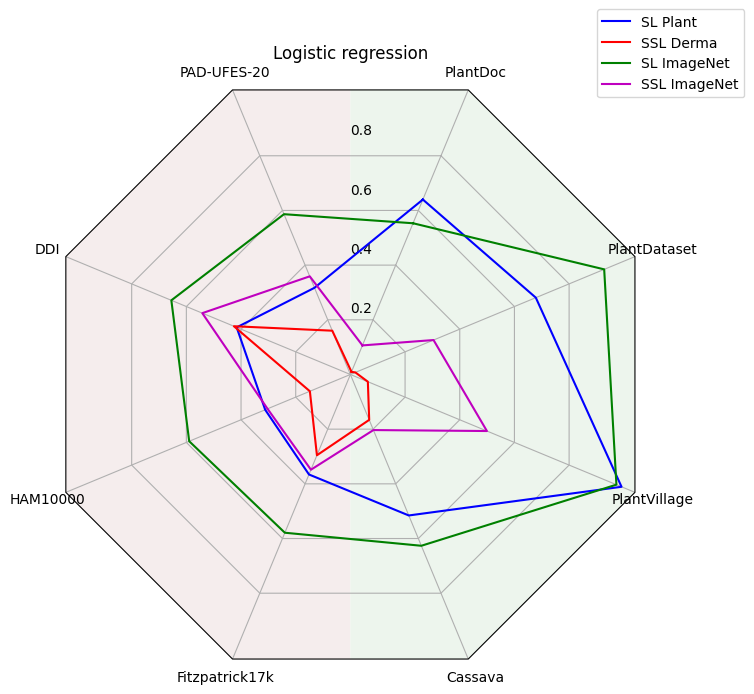

In [5]:
colors = ["b", "r", "g", "m", "y"]

number_of_categories = len(df_plot.columns)
rotation_offset=np.pi/2-np.pi/number_of_categories
theta = radar_factory(number_of_categories, frame="polygon", rotation_offset=rotation_offset)

fig, axes = plt.subplots(
    figsize=(8, 8),
    nrows=1,
    ncols=1,
    subplot_kw=dict(projection="radar"),
    squeeze=False,
)

ax = axes.flat[0]
for i, (index, row) in enumerate(df_plot.iterrows()):
    color = colors[i] if i < len(colors) else None
    ax.set_theta_offset(rotation_offset)
    ax.plot(theta, row.values, color=color, label=index)
    # ax.fill(theta, row.values, facecolor=color, alpha=0.15) # , label="_nolegend_"

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
ax.set_title(title)
ax.set_varlabels(df_plot.columns)
# ax.legend(df_plot.index.values, loc=(0.9, 0.95), labelspacing=0.1, fontsize="small")
north = np.pi/2-rotation_offset
ax.axvspan(north, np.pi+north, facecolor=(0.95, 0.9, 0.9), alpha=0.7) # red
ax.axvspan(np.pi+north, 2*np.pi+north, facecolor=(0.9, 0.95, 0.9), alpha=0.7) # green
plt.legend(loc=(0.9, 0.95))